### 1. Loda the data in Cosmos DB Analytical store collection 


In [11]:
df_IoTSignals = spark.read\
                    .format("cosmos.olap")\
                    .option("spark.synapse.linkedService", "CosmosDemo")\
                    .option("spark.cosmos.container", "IoTSignals")\
                    .load()

StatementMeta(sparkpool, 4, 3, Finished, Available)

### 2. Data exploration using pyplot


StatementMeta(sparkpool, 4, 4, Finished, Available)

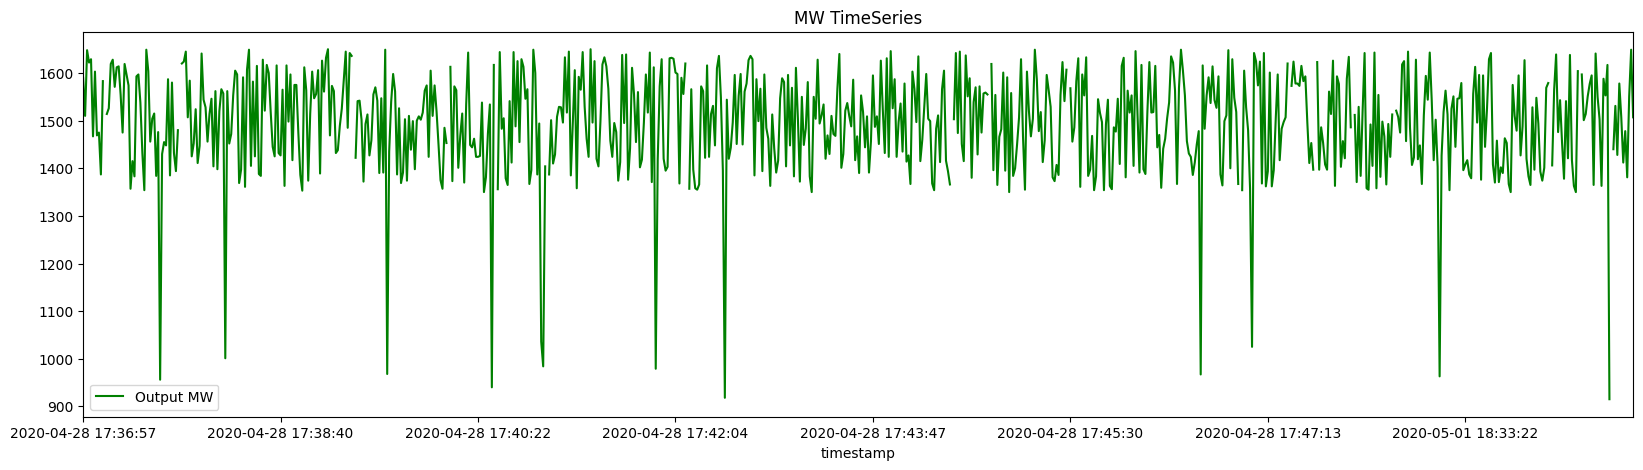

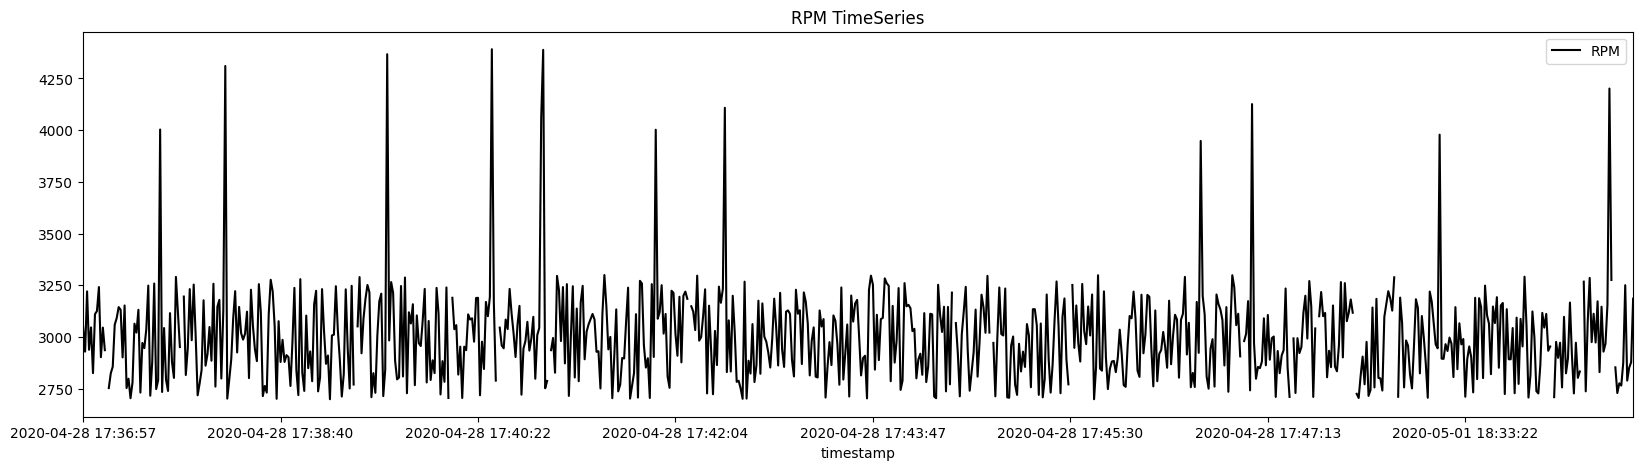

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df_IoTSignals_pd = df_IoTSignals.toPandas()
df_dev = df_IoTSignals_pd[(df_IoTSignals_pd.deviceId == "dev-1")]
df_dev = df_dev.dropna()
df_dev = df_dev.astype({"measureValue": int})
#display(df_dev)
df_dev = df_dev.pivot(index='dateTime', columns = 'unitSymbol' , values =  'measureValue')
df_dev['timestamp']=df_dev.index
df_dev['index']=list(range(len(df_dev)))
df_dev.set_index('index',inplace=True)
df_dev.plot(y='MW', x= 'timestamp', color='green',figsize=(20,5), label = 'Output MW')
plt.title('MW TimeSeries')
df_dev.plot(y='RPM', x= 'timestamp', color='black', figsize=(20,5), label = 'RPM')
plt.title('RPM TimeSeries')
plt.legend(loc = 'best')
plt.show()

### 3. Perform anomaly detection using Microsoft Machine Learning for Spark (MMLSpark)


In [13]:
from pyspark.sql.functions import col
from mmlspark.cognitive import SimpleDetectAnomalies
from mmlspark.core.spark import FluentAPI

anomaly_detector = (SimpleDetectAnomalies()
                            .setSubscriptionKey("<Azure Anomaly Detector Key>")
                            .setUrl("<Azure Anomaly Detector End Point>/anomalydetector/v1.0/timeseries/entire/detect")
                            .setOutputCol("anomalies")
                            .setGroupbyCol("grouping")
                            .setSensitivity(95)
                            .setGranularity("secondly"))

df_anomaly = (df_IoTSignals
                    .where(col("unitSymbol") == 'RPM')
                    .withColumnRenamed("dateTime", "timestamp")
                    .withColumn("value", col("measureValue").cast("double"))
                    .withColumn("grouping", col("deviceId"))
                    .mlTransform(anomaly_detector))

df_anomaly.createOrReplaceTempView('df_anomaly')

StatementMeta(sparkpool, 4, 5, Finished, Available)

In [14]:
display(df_anomaly)

StatementMeta(sparkpool, 4, 6, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2ea4873b-afdf-4e96-8a33-aaa911ddb59a)

### 4. Format the dataframe for visualization


In [15]:
df_anomaly_single_device = spark.sql("select timestamp \
                                            , measureValue \
                                            , anomalies.expectedValue \
                                            , anomalies.expectedValue + anomalies.upperMargin as expectedUpperValue \
                                            , anomalies.expectedValue - anomalies.lowerMargin as expectedLowerValue \
                                            , case when anomalies.isAnomaly=true then 1 else 0 end as isAnomaly \
                                        from df_anomaly \
                                        where deviceid = 'dev-1' and timestamp < '2020-12-29'\
                                        order by timestamp \
                                        limit 200")

display(df_anomaly_single_device)  

StatementMeta(sparkpool, 4, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 0670d0b2-a7d4-4da6-9e5e-e04bd5dc8582)

### 5. Visualize the anomalies using plotly
* Plot Expected value, Upper Value, Lower Value and Actual Value along with Anomaly flag


StatementMeta(sparkpool, 4, 11, Finished, Available)

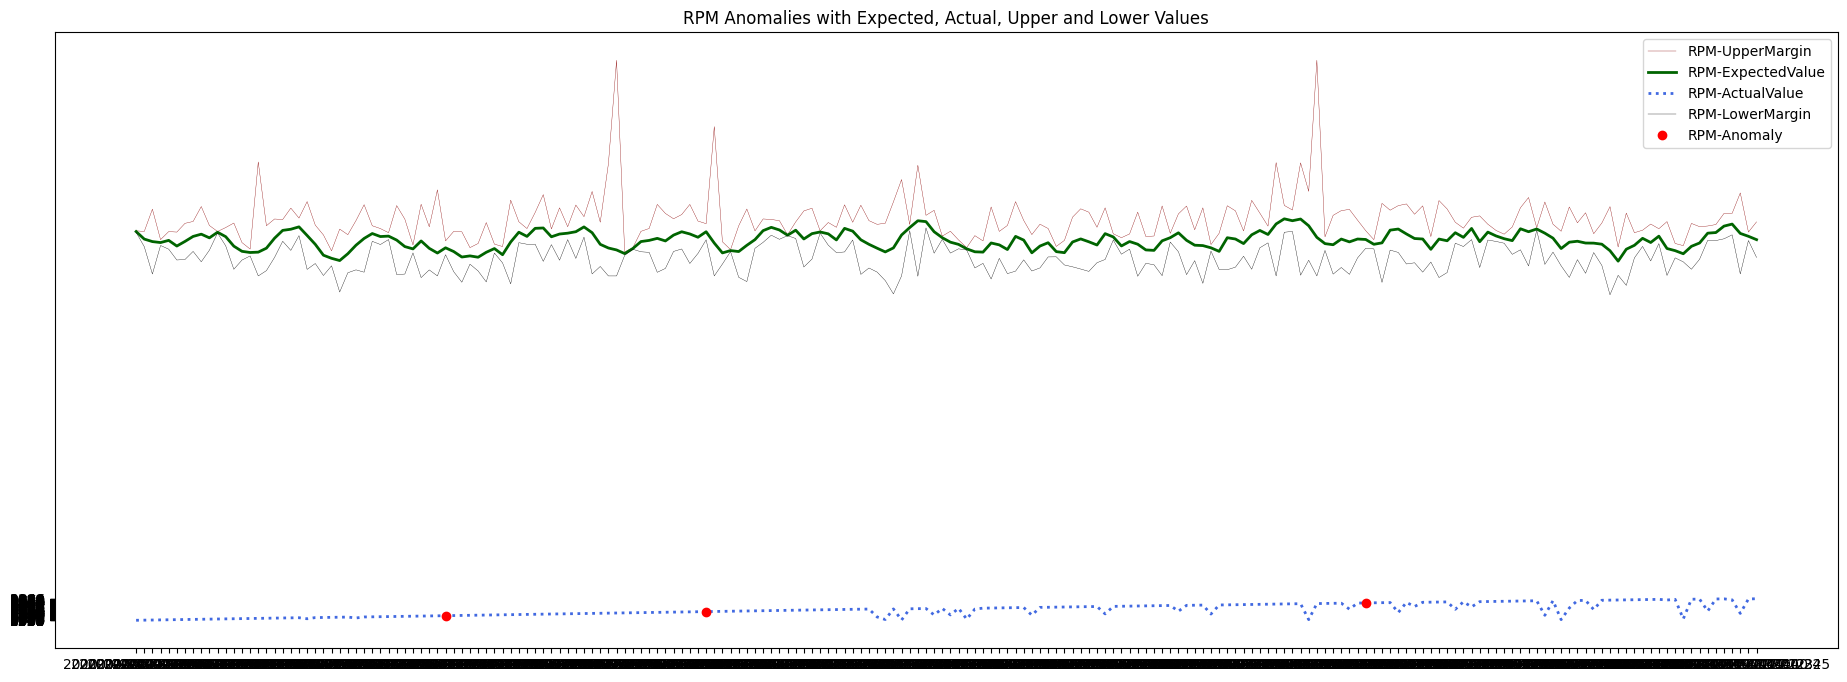

In [19]:
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from matplotlib.pyplot import figure
 
adf = df_anomaly_single_device.toPandas()
adf_subset = df_anomaly_single_device.where(col("isAnomaly") == 1).toPandas() 

plt.figure(figsize=(23,8))
plt.plot(adf['timestamp'],adf['expectedUpperValue'], color='darkred', linestyle='solid', linewidth=0.25)
plt.plot(adf['timestamp'],adf['expectedValue'], color='darkgreen', linestyle='solid', linewidth=2)
plt.plot(adf['timestamp'],adf['measureValue'], 'b', color='royalblue', linestyle='dotted', linewidth=2)
plt.plot(adf['timestamp'],adf['expectedLowerValue'],  color='black', linestyle='solid', linewidth=0.25)
plt.plot(adf_subset['timestamp'],adf_subset['measureValue'], 'ro')
plt.legend(['RPM-UpperMargin', 'RPM-ExpectedValue', 'RPM-ActualValue', 'RPM-LowerMargin', 'RPM-Anomaly'])
plt.title('RPM Anomalies with Expected, Actual, Upper and Lower Values')
plt.show()